# Creating the Vocabulary

In [1]:
import spacy
spacy_eng = spacy.load("en")
class Vocabulary:
    PAD_token = 0   # Used for padding short sentences
    SOS_token = 1   # Start-of-sentence token
    EOS_token = 2   # End-of-sentence token

    def __init__(self, name):
        self.name = name
        self.word2index = {'PAD': 0, 'SOS': 1, 'EOS': 2}
        self.word2count = {}
        self.index2word = {0: "PAD", 1: "SOS", 2: "EOS"}
        self.num_words = 3
        self.num_sentences = 0 
        self.longest_sentence = 0
    


    def add_word(self, word):
        if word not in self.word2index:
            # First entry of word into vocabulary
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            # Word exists; increase word count
            self.word2count[word] += 1
            
    def tokenizer(self,text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]
    
    def add_sentence(self, sentence):
        sentence_len = 0
        #for word in sentence.split(' '):
        for word in self.tokenizer(sentence):
            sentence_len += 1
            self.add_word(word)
        if sentence_len > self.longest_sentence:
            # This is the longest sentence
            self.longest_sentence = sentence_len
        # Count the number of sentences
        self.num_sentences += 1

    def to_word(self, index):
        return self.index2word[index]

    def to_index(self, word):
        return self.word2index[word]

In [2]:
import pandas as pd
import re
df = pd.read_csv('../input/flickr-image-dataset/flickr30k_images/results.csv',delimiter='|')
df[' comment'] = df[' comment'].str.lower()
df[' comment'].replace( { r'[^a-zA-Z0-9, ]' : '' }, inplace= True, regex = True)

# fixing an issue in the dataset.
df[' comment_number'][19999] = 4
df[' comment'][19999] = ' a dog runs across the grass '

# creating the vocabulary 
vocab = Vocabulary('test')

# adding words to the vocabulary 
for sentence in df[' comment']:
    vocab.add_sentence(sentence)

# converting the captions to tokens 
sent_idxs = []
captions = []
for idx, sentence in enumerate (df[' comment']):
    i = 0
    '''for word in sentence.split(' '):
        if i==0:
            sent_idxs.append(1)
        index = vocab.to_index(word)    
        if index != 3:    
            sent_idxs.append(index)
        elif index == 3 and i !=0:
            sent_idxs.append(2)
        i+=1'''
    #for word in sentence.split(' '):
    for word in vocab.tokenizer(sentence):
        sent_idxs.append(vocab.to_index(word))
        i+=1
    while i < ((vocab.longest_sentence) + 1):
        sent_idxs.append(0)
        i+=1
    captions.append(sent_idxs)
    sent_idxs = []

# converting list of word tokens to numpy array
import numpy as np
captions = np.array(captions)
captions.shape

(158915, 83)

In [3]:
# adding start and end tokens
for i in range(len(captions)):
    for j in range(1,84):
        if captions[i,j] == 0:
            if captions[i,j-1] == 3:
                captions[i,j-1] = 2
            else:
                captions[i,j] = 2
            break  
captions[:,0] = 1

# Loading the embeddings

In [4]:
import numpy as np 
vocabs = vocab.word2index.keys()

def load_embeds(root_dir):
    embeddings_index = dict()
    f = open(root_dir)

    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

    f.close()
    return embeddings_index
embeddings_index = load_embeds('../input/glove6b300dtxt/glove.6B.300d.txt')

In [5]:
embeddings_index['the']

array([ 4.6560e-02,  2.1318e-01, -7.4364e-03, -4.5854e-01, -3.5639e-02,
        2.3643e-01, -2.8836e-01,  2.1521e-01, -1.3486e-01, -1.6413e+00,
       -2.6091e-01,  3.2434e-02,  5.6621e-02, -4.3296e-02, -2.1672e-02,
        2.2476e-01, -7.5129e-02, -6.7018e-02, -1.4247e-01,  3.8825e-02,
       -1.8951e-01,  2.9977e-01,  3.9305e-01,  1.7887e-01, -1.7343e-01,
       -2.1178e-01,  2.3617e-01, -6.3681e-02, -4.2318e-01, -1.1661e-01,
        9.3754e-02,  1.7296e-01, -3.3073e-01,  4.9112e-01, -6.8995e-01,
       -9.2462e-02,  2.4742e-01, -1.7991e-01,  9.7908e-02,  8.3118e-02,
        1.5299e-01, -2.7276e-01, -3.8934e-02,  5.4453e-01,  5.3737e-01,
        2.9105e-01, -7.3514e-03,  4.7880e-02, -4.0760e-01, -2.6759e-02,
        1.7919e-01,  1.0977e-02, -1.0963e-01, -2.6395e-01,  7.3990e-02,
        2.6236e-01, -1.5080e-01,  3.4623e-01,  2.5758e-01,  1.1971e-01,
       -3.7135e-02, -7.1593e-02,  4.3898e-01, -4.0764e-02,  1.6425e-02,
       -4.4640e-01,  1.7197e-01,  4.6246e-02,  5.8639e-02,  4.14

In [6]:
import torch
def load_embed_weights(embeddings_index, embed_dim, vocab, vocab_size):
    matrix_len = vocab_size
    weights_matrix = np.zeros((matrix_len, embed_dim))
    words_found = 0

    for i, word in enumerate(vocab):
        try: 
            weights_matrix[i] = embeddings_index[word]
            words_found += 1
        except KeyError:
            weights_matrix[i] = np.random.normal(scale=0.6, size=(embed_dim, ))
    weights_matrix = torch.tensor(weights_matrix)
    return weights_matrix
weights_matrix = load_embed_weights(embeddings_index, 300, vocabs, vocab.num_words)
weights_matrix.shape

torch.Size([19997, 300])

# Some helper functions which we will be using later

In [7]:
def output_to_caption(outputs, index):
    preds = outputs[index]
    preds = torch.argmax(preds, dim = 1)
    preds = preds.cpu()
    preds = np.array(preds)
    for index in preds:
        if index == 2:
            break    
        if index != 1:    
            print(vocab.to_word(index), end = ' ')

def tensor_to_caption(preds, index):
    preds = preds[index].cpu()
    preds = np.array(preds)
    for index in preds:
        if index == 2:
            break
        if index != 1:    
            print(vocab.to_word(index), end = ' ')

def tensor_to_image(img_list, index):
    img = img_list[index].permute(1,2,0)
    plt.figure()
    plt.imshow(img.cpu())

# Creating the dataloader

a man in a black coat walks past a red spaceship with a parking ticket stuck to its window 

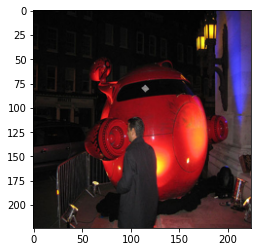

In [8]:
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from glob import glob
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


class Data(Dataset):

    def __init__(self, root_dir, captions):
        
        self.root_dir = root_dir
        self.df = pd.read_csv(root_dir+'results.csv', delimiter = '|')
        self.captions_tensor = torch.tensor(captions)
        self.captions = captions
        self.imgloc = self.df['image_name']
        self.img_list = glob(root_dir+'flickr30k_images/*')
    
    def __getcaption__(self,index):
        return self.captions[5*index]
    
    def __getitem__(self,index):
        
        img = self.root_dir+'flickr30k_images/'+ self.imgloc[5*index]
        caption = self.captions[5*index]
        img_tensor = (torch.tensor(np.array(Image.open(img).resize((224,224)))).permute(2,0,1) )/255
        return img_tensor, caption
    
    def __len__(self):
        return (len(self.img_list)-2)


data = Data('../input/flickr-image-dataset/flickr30k_images/', captions)
img, caption_tensor = data.__getitem__(69)
caption = data.__getcaption__(69)
plt.imshow(img.permute(1,2,0))
for idx in caption:
    if idx == 1:
        continue
    if idx !=2:
        print(vocab.to_word(idx), end =" ")
    else:
        break

a barefoot young girl in a pink gown is asleep on a hard wood floor cuddling her baby doll 

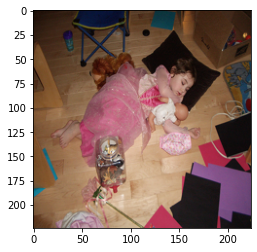

In [9]:
batch_size = 32
data_len = len(data)
trainset, valset = random_split(data, [int(0.8*data_len), (data_len - int(0.8*data_len))])
trainloader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle = True)
valloader = DataLoader(dataset=valset, batch_size=batch_size, shuffle = True)
for img_list, caption in trainloader:
    plt.imshow(img_list[4].permute(1,2,0))
    tensor_to_caption(caption,4)
    break

# Encoder

In [10]:
#import torchvision
#import torch.nn as  nn
#model = torchvision.models.vgg16(pretrained=True)
#for param in model.parameters():
#    param.requires_grad = False
#model = model.features[:30]
#model

In [11]:
import torchvision
import torch.nn as  nn
model = torchvision.models.resnet50(pretrained=True)
for param in model.parameters():
       param.requires_grad = False
model = torch.nn.Sequential(*(list(model.children())[:-2]))
model


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


# Attention (soft)

In [12]:
'''class attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.fc = nn.Linear(hidden_dim*2, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim = 1)

    def forward(self, features, hidden_state):
        # features = [32,196,512], hidden_state = [32,512]
        hidden_state = hidden_state.unsqueeze(1)       #[32,1,512]
        ones = torch.ones(features.shape[1],1)  #[196,1]
        ones = ones.to(device)      
        hidden_state = ones @ hidden_state         #[32,196,512]

        combine = torch.cat((features, hidden_state), dim = 2)   #[32,196,1024]
        combine = combine.to(device)

        attn_weights = []

        for image in combine:
            #image = 196,1024
            out = self.relu(self.fc(image))  #[196,1]         
            out = out.squeeze(1)              #[196]
            attn_weights.append(out)

        # attn_weights = [32,196]
        attn_weights = torch.stack(attn_weights)    
        attn_weights = self.softmax(attn_weights)
        attn_weights = attn_weights.unsqueeze(1)  #[32,1,196]

        context = attn_weights @ features         #[32,1,512]

        return context.squeeze(1)                 #[32,512]'''

'class attention(nn.Module):\n    def __init__(self, hidden_dim):\n        super().__init__()\n        self.fc = nn.Linear(hidden_dim*2, 1)\n        self.relu = nn.ReLU()\n        self.softmax = nn.Softmax(dim = 1)\n\n    def forward(self, features, hidden_state):\n        # features = [32,196,512], hidden_state = [32,512]\n        hidden_state = hidden_state.unsqueeze(1)       #[32,1,512]\n        ones = torch.ones(features.shape[1],1)  #[196,1]\n        ones = ones.to(device)      \n        hidden_state = ones @ hidden_state         #[32,196,512]\n\n        combine = torch.cat((features, hidden_state), dim = 2)   #[32,196,1024]\n        combine = combine.to(device)\n\n        attn_weights = []\n\n        for image in combine:\n            #image = 196,1024\n            out = self.relu(self.fc(image))  #[196,1]         \n            out = out.squeeze(1)              #[196]\n            attn_weights.append(out)\n\n        # attn_weights = [32,196]\n        attn_weights = torch.stack(at

In [13]:
class attention(nn.Module):
  def __init__(self, feature_dim, hidden_dim, embed_dim, num_vecs):
    super().__init__()
    
    self.features_fc = nn.Linear(feature_dim, num_vecs)
    self.hidden_fc = nn.Linear(hidden_dim, num_vecs)
    self.context_fc = nn.Linear(num_vecs, 1)
    self.input_fc = nn.Linear(embed_dim, hidden_dim)
    self.hidden_gate_fc = nn.Linear(hidden_dim, hidden_dim)
    self.s_fc = nn.Linear(hidden_dim, num_vecs)
    self.ones = torch.ones(num_vecs,1).to(device)
    self.tanh = torch.tanh
    self.sigma = torch.sigmoid
  
  def forward(self, features, hidden, inputs, memory):

    c1 = []
    #c1 = c1.to(device)
    for i in range(features.shape[0]):
      f = self.features_fc(features[i,:,:])            #3,3
      h = self.hidden_fc(hidden[i,:].unsqueeze(0))     #1,3
      h1 = self.ones @ h
      c = self.tanh(f+h1)                               #3,3
      z = self.context_fc(c).permute((1,0))            #1,3
      a = F.softmax(z, dim = 1)
      test = a @ features[i,:,:]

    
      gate = self.sigma( self.input_fc(inputs[i,:]) + self.hidden_gate_fc(hidden[i,:]) )
      s = gate * self.tanh(memory[i,:])                
  
      ws = self.s_fc(s.unsqueeze(0))                   #1,3
      
      w = self.tanh(ws+h)                              #1,3
      i = self.context_fc(w)                           
      
      concat = F.softmax(torch.cat((z,i), dim = 1), dim = 1).squeeze(0)
      b = concat[-1]
  
      c1b = b*s + (1-b)*(test)
      c1.append(c1b)


    c1 = torch.stack(c1)

    return  c1.squeeze(1)

# Decoder

In [14]:
class Decoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, weights_matrix, device, attn, num_layers=1):
        super(Decoder, self).__init__()
        
        # define the properties
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        
        # lstm cell
        #self.lstm_cell = nn.LSTMCell(input_size = embed_size + hidden_size, hidden_size=hidden_size)
        self.lstm_cell = nn.LSTMCell(input_size = embed_size, hidden_size=hidden_size)
        # output fully connected layer
        self.fc_out = nn.Linear(in_features = self.hidden_size*2, out_features = self.vocab_size)
    
        # embedding layer
        self.embed = nn.Embedding(num_embeddings = self.vocab_size, embedding_dim = self.embed_size)
        self.embed.weight.requires_grad = False
        self.embed.load_state_dict({'weight': weights_matrix})
        
        #self.embed_test = nn.Embedding(num_embeddings = self.vocab_size, embedding_dim = self.embed_size)
        #self.embed_test.weight.requires_grad = False
        #self.embed_test.load_state_dict({'weight': weights_matrix})
         
    def forward(self, features, captions, test = False):


        # features = [32,196,512], captions = [32,num_words]
        
        # batch size
        batch_size = features.size(0)    # 32
        
        # init the hidden and cell states to zeros
        
        #hidden_state = torch.zeros((batch_size, self.hidden_size)).to(device)    #[32,512]
        #cell_state = torch.zeros((batch_size, self.hidden_size)).to(device)      #[32,512]
        
        hidden_state = torch.mean(features, dim = 1)    #[32,512]
        cell_state = torch.mean(features, dim = 1)      #[32,512]
        
        outputs = torch.empty((batch_size, captions.size(1), self.vocab_size)).to(device) #captions.size(1) is the number of words 
        # outputs = [32,num_words,vocab_size]
        
        # embed the captions
        captions_embed = self.embed(captions)    #[32,num_words,300]
        
        # pass the caption word by word
        if test == False: 
            for t in range(captions.size(1)):

                # getting the features of the image to be focussed on  
                #context = attn(features, hidden_state)  #[32,512]

                # concatnating it with the input word
                #inputs = torch.cat((context, captions_embed[:, t, :]), dim = 1) # [32,812] 

                #passing the combination through lstm
                #hidden_state, cell_state = self.lstm_cell(inputs, (hidden_state, cell_state))
                hidden_state, cell_state = self.lstm_cell(captions_embed[:,t,:], (hidden_state, cell_state))


                context = attn(features, hidden_state, captions_embed[:,t,:], cell_state)

                out = torch.cat((context, hidden_state), dim = 1)
                # output of the attention mechanism
                out = self.fc_out(out)

                # build the output tensor
                outputs[:, t, :] = out      

            return F.log_softmax(outputs, dim = 2)
        
        else:
            
            word_idxs = torch.ones(batch_size).long().to(device)
            
            for i in range(captions.size(1)):
                
                word_embeds = self.embed(word_idxs)     #[32,300]
            
                
                hidden_state, cell_state = self.lstm_cell(word_embeds, (hidden_state, cell_state))


                context = attn(features, hidden_state, word_embeds, cell_state)

                out = torch.cat((context, hidden_state), dim = 1)
                # output of the attention mechanism
                out = self.fc_out(out)
            
                # build the output tensor
                outputs[:, i, :] = out
                
                word_idxs = torch.argmax(out, dim = 1)

            return F.log_softmax(outputs, dim = 2)

                
            
        
        
        
vocab_size = vocab.num_words
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
attn = attention(2048, 2048, 300, 49)
attn = attn.to(device)
decoder = Decoder(300,2048, vocab_size,weights_matrix, device, attn)

# Training function

In [15]:
import pyprind
def train(encoder, decoder, trainloader, criterion, optimizer_decoder, epoch, device):
    best_loss = 100
    train_loss = []
    bar = pyprind.ProgBar(len(trainloader), bar_char='█')
    for idx, (img_list, caption) in enumerate (trainloader):

        img_list = img_list.to(device)
        caption_target = caption[:,1:]    # skips SOS
        caption_train = caption[:,:-1]    # skips EOS
        caption_target, caption_train = caption_target.to(device).long(), caption_train.to(device).long()
        features = encoder(img_list) # [32,512,49,49]
        features = features.permute(0,2,3,1)    # [32,7,7,2048]
        features = features.view(-1, 49, 2048) # [32,196,512]
        outputs = decoder(features, caption_train)
        #optimizer_encoder.zero_grad()
        optimizer_decoder.zero_grad()
        
        loss = criterion(outputs.view(-1, vocab_size), caption_target.contiguous().view(-1))
        
        train_loss.append(loss.item())
        
        loss.backward()
        #optimizer_encoder.step()
        optimizer_decoder.step()
        bar.update()
        
        
    print('\ntrain loss : {}\n'.format(np.mean(train_loss)))
    if np.mean(train_loss) < best_loss:
        best_loss = np.mean(train_loss)
        torch.save(decoder.state_dict(), 'weights_decoder.pth')
    print('\npredicted caption:')
    output_to_caption(outputs, 1)
    print("\n\nactual caption:")
    tensor_to_caption(caption, 1)
    print()

# Training

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.NLLLoss(ignore_index = 0 )
criterion.to(device)
encoder = model
optimizer_decoder = torch.optim.Adam(decoder.parameters(), lr = 1e-2)
#optimizer_encoder = torch.optim.Adam(encoder.parameters(), lr = 1e-2)
encoder.to(device)
decoder.to(device)
epochs = 5
#decoder.load_state_dict(torch.load('../input/v1thridrunweights/weights_decoder_run2.pth'))
for epoch in range(epochs):
    train(encoder, decoder, trainloader, criterion, optimizer_decoder, epoch, device)
print("OVERALL TRAINING COMPLETE")
    

0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 01:31:32



train loss : 9.155026948077124


predicted caption:
a man wearing standing through a sidewalk 

actual caption:
a woman is walking on the street in front of a yellow car with the driver s side window open 


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 01:27:46



train loss : 7.334001456566576


predicted caption:
a performer boy in a yellow outfit sitting sitting a metallic girl sitting a yellow outfit sitting sitting on a ground with a a on on 

actual caption:
a young boy in a red shirt , and a young girl in a white shirt are sitting on the ground 


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 01:27:34



train loss : 7.125865736547506


predicted caption:
a a blue a a blue in a purple shirt and to to a a purple 

actual caption:
while in switzerland , a man in a blue sweater waits forlornly and has a beer 


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 01:27:44



train loss : 7.325655659489661


predicted caption:
basketball man player in a uniform uniform are in other in the basketball in uniform uniform uniform jumps orange are standing women other referee stands 

actual caption:
a basketball player in a red uniform blocks the shot of a player in a white uniform and glasses while other while a referee watches and other players and onlookers sit behind them 


0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 01:29:19



train loss : 7.561118320249162


predicted caption:
a man wearing a blue shirt hat holds a candle candle purse in hugging on a his forehead 

actual caption:
a man in a white cotton shirt holds a lit blue candle and stands while touching his forehead to the foot of a statue on top of a pillar 
OVERALL TRAINING COMPLETE


# Checking the captions for random pictures in the valset

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.NLLLoss(ignore_index = 0 )
criterion.to(device)
encoder = model
optimizer_decoder = torch.optim.Adam(decoder.parameters(), lr = 1e-2)
#optimizer_encoder = torch.optim.Adam(encoder.parameters(), lr = 1e-2)
encoder.to(device)
decoder.to(device)
for idx, (img_list, caption) in enumerate (valloader):

        img_list = img_list.to(device)
        caption_target = caption[:,1:]
        caption_train = caption[:,:-1]
        caption_target, caption_train = caption_target.to(device).long(), caption_train.to(device).long()
        features = encoder(img_list) # [32,512,49,49]
        features = features.permute(0,2,3,1)    # [32,49,49,512]
        features = features.view(-1, 49, 2048) # [32,196,512]
        outputs1 = decoder(features, caption_train, test = True)
        outputs2 = decoder(features, caption_train)
        break

# Using greedy decoding


predicted caption:
a brown and white dog is running along a hay bale , leaning against a foggy beach 

actual caption:
a corgi jumps off a bale of hay , m water and buildings behind it 


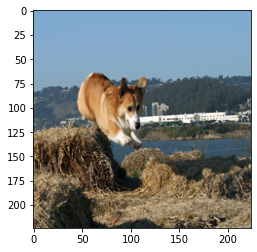

In [18]:
print('\npredicted caption:')
output_to_caption(outputs1, 20)
print("\n\nactual caption:")
tensor_to_caption(caption, 20)
print()
tensor_to_image(img_list, 20)